# Scrapping Digital Library ITB



## Pendahuluan

Salah satu program kerja di divisi Penelitian HIMATIKA ITB adalah "Lex Luthor's Database". Secara sederhana, proker ini bertugas untuk mencatat segala hal (baik kondisi internal maupun eksternal himpuunan) ke sebuah database. Dengan adanya database ini, diharapkan anggota himpunan (termasuk badan pengurus himpunan) dapat menerapkan kebijakan yang berbasis data.

Satu hal yang termasuk dalam proses pencatatan data ini adalah data mengenai Tugas Akhir mahasiswa matematika. Sampai saat saya menulis ini, hanya ada dua cara untuk mengetahui data TA ini. Pertama, dengan datang langsung ke Perpustakaan Program Studi Matematika, dan menggunakan fasilitas komputer disana, atau dengan mengakses website [Digital Library ITB](www.digilib.itb.ac.id). Namun kedua cara ini memiliki kekurangan yang jelas:
* Anda perlu datang ke perpus hanya untuk mencari data TA.
* Fasilitas "Pencarian Lanjut" di website Digital Library yang rusak.
Keadaan inilah yang mendasari mengapa data Tugas Akhir perlu disimpan ke sebuah database. [Walau ini hanya separuh dari cerita sebenarnya]

Ditugaskan untuk melakukan pendataan ini, saya mencoba berdiskusi mengenai *sharing* data TA dari pihak perpustakaan prodi. Namun karena hal ini mengalami kegagalan, saya memutuskan untuk melakukan *scrapping* website Digital Library.

## Scrapping

untuk bagian ini, kita memerlukan beberapa *module* penting:
* `re` akan digunakan untuk mengolah teks dengan efisien.
* `pickle` berguna untuk metode penyimpanan sementara data hasil *scrapping*
* `numpy` dan `pandas` punya banyak metode bagus untuk mengolah data berukuran besar.
* `urllib` dan `bs4` masing-masing digunakan untuk proses *scrapping*
* `tqdm` sebagai penunjuk *progress bar* (setidaknya penting dalam proses debugging)

In [1]:
import re

import pickle
import numpy as np
import pandas as pd 

import urllib.request as U
from bs4 import BeautifulSoup as bs

from tqdm import tqdm

Selanjutnya, kita perlu sebuah fungsi untuk mengambil data dari halaman Digital Library. Beruntungnya, setiap *record* data di website ini disimpan secara sekuensial:

`https://digilib.itb.ac.id/index.php/gdl/view/{no_record}`

dengan demikian, proses *scrapping* tidaklah terlalu sulit. Dengan mengamati struktur HTML dari halaman record, saya membuat fungsi untuk mengambil data dari **sebuah halaman** Digital Library

In [2]:
URL = 'https://digilib.itb.ac.id/index.php/gdl/view/{}'

def dictify(num):
    res = {}

    try:
        # baca data HTML
        with U.urlopen(URL.format(num)) as f:
            raw = f.read().decode('utf8', 'ignore')
            soup = bs(raw, 'html.parser')
        
        # ambil info judul dan abstrak
        tmp = []
        for p in soup.findAll('p')[1:]:
            # pakai try-except karna ada p tanpa class cuma <p>
            try:
                if 'text-left' in p['class']:
                    tmp2 = re.sub('(\n|\r|\t)', '', p.decode_contents())
                    tmp2 = re.sub(' +', ' ', tmp2)
                    tmp.append(tmp2.strip())
            except:
                pass
        res['judul'] = tmp[0]
        if len(tmp[1]) >= 3:
            res['abstrak'] = tmp[1]

        # ambil info penulis
        tmp = soup.findAll('blockquote')[0]
        res['oleh'] = tmp.findAll('b')[0].decode_contents().strip()
        
        # ambil info lainnya, tersimpan sebagai table 
        for tr in tmp.findAll('tr'):
            cols = [x.decode_contents() for x in tr.findAll('td')]
            key = cols[0]
            val = re.sub('(<. [^>]*>|<\/.>)', '', cols[2])
            val = re.sub('(\n|\r|\t)', '', val)
            val = re.sub(' +', ' ', val)
            
            if val!='':
                if key=='Kontributor / Dosen Pembimbing' and len(val) >= 3: res['kontributor'] = val
                elif key=='Jenis Koleksi': res['jenis'] = val
                elif key=='Penerbit': res['penerbit'] = val
                elif key=='Fakultas': res['fakultas'] = val
                elif key=='Subjek': res['subjek'] = val
                elif key=='Kata Kunci': res['kunci'] = val
                elif key=='Tanggal Input': res['tanggal'] = val
    
    # dalam kasus ada error
    except:
        pass

    return res

In [3]:
dictify(45555)

{'abstrak': 'Indonesia merupakan salah satu negara dengan angka kejadian tuberkulosis (TB) yang tinggi.Pengobatan TB merupakan terapi yang membutuhkan waktu lama dan menggunakan kombinasi obatuntuk penanganannya (obat antituberkulosis kombinasi dosis tetap) sehingga kemungkinan terjadinyareaksi obat merugikan (ROM) cukup besar. Terdapat kemungkinan terjadinya penghentian obat atauketidakpatuhan karena munculnya ROM pada pasien. Penelitian ini bertujuan untuk mengidentifikasireaksi obat merugikan (ROM) dari obat anti tuberkulosis lini pertama, pola kejadian dari ROM,penanganan terhadap ROM, dan hubungannya dengan kepatuhan pasien. Penelitian ini merupakanstudi potong lintang yang dilakukan secara retrospektif dan konkuren melalui wawancara pada pasienserta tenaga medis yang bertugas dan data rekam medik pasien di Poliklinik DOTS RSUP Dr. HasanSadikin Bandung. Teridentifikasi adanya reaksi obat merugikan (ROM) berupa mual dengan atautanpa muntah (41,75%), reaksi kulit (27,18%), nyeri sen

Setidaknya ada 46k data yang perlu kita simpan. Untuk mempermudah keadaan (dan juga *debugging* ketika terjadi error), saya membuat sebuah fungsi untuk mengautomasi proses download. 

In [4]:
def batch_download(start, end, batch_size=50):
    for batch in range(start, end+1, batch_size):
        
        result = {}
        for num in tqdm(range(batch, batch+batch_size), desc=str(batch)):
            tmp = str(num)
            result[tmp] = dictify(tmp)

        with open('pickle_'+tmp, 'wb') as outfile:
            pickle.dump(result, outfile, -1)

In [5]:
#batch_download(45076, 46044)

selanjutnya kita tinggal menggabungkan semua pickle yang telah tersimpan

In [6]:
result = {}
for n in range(45125, 46076, 50):
    with open('pickle_{}'.format(n), 'rb') as outfile:
        result.update(pickle.load(outfile))

data = pd.DataFrame.from_dict(result, orient='index')

In [7]:
data.tail()

,judul,abstrak,oleh,kontributor,jenis,penerbit,fakultas,subjek,kunci,tanggal
46040,SCALING HYPOTHESIS OF A SPATIAL SEARCH ON FRAC...,We investigate a quantum spatial search proble...,Rei Sato [-],Tetsuro Nikuni and Shohei Watabe,Jurnal elektronik,FMIPA - Fisika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,Physics,-,2020-02-11 14:07:58
46041,BROADBAND ANALYSIS AND SELF-CONTROL OF SPECTRA...,Carrier-envelope and optical phase noise of a ...,A. Liehl [-],"P. Sulzer, D. Fehrenbacher, S. Eggert, M. Ludw...",Jurnal elektronik,FMIPA - Fisika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,Physics,-,2020-02-11 14:16:21
46042,PERANCANGAN DAN PEMILIHAN SISTEM HVAC PADA BAN...,"Heating, ventilation, and air conditioning (pe...",Erin Puspa Gayatri [13116601],Dr. Ir. Prihadi Setyo Darmanto;,S1-Tugas Akhir,FTMD - Teknik Mesin,Fakultas Teknik Mesin dan Dirgantara (FTMD),NaN,"Sistem HVAC, bangunan kantor, rancangan siste...",2020-02-11 14:18:49
46043,EVAPORATIVE COOLING FROM AN OPTICAL DIPOLE TRA...,"In recent years, cold atoms could prove their ...",Christian Vogt [-],"Marian Woltmann, Sven Herrmann, and Claus Lämm...",Jurnal elektronik,FMIPA - Fisika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,Physics,-,2020-02-11 14:22:58
46044,PENDETEKSIAN HASIL GROUTING PADA OVERBREAK DI ...,Ground penetrating radar adalah teknik yang me...,Faris Yudza Ghifari [10216054],"Drs. Gunawan Handayani, MSCE, Ph.D.;",S1-Tugas Akhir,FMIPA - Fisika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,NaN,"Cavity, Common Offset, Frekuensi, Grouting, MA...",2020-02-11 14:48:13


karena kita perlu mengubah data ini ke bentuk CSV, kita perlu cari separator yang cocok untuk data ini. Untuk kasus ini, kita akan memakai simbol dollar `$` karena simbol ini jarang digunakan (memperkecil peluang untuk merusak data mentah). Namun karena

In [8]:
'$' in data.to_string()

True

kita perlu membuang karakter ini dari DataFrame (padahal, 45k data pertama tidak ada mengandung simbol ini) :(

In [9]:
data = data.replace({'\$':''}, regex=True)
'$' in data.to_string()

False

*sebelumnya, saya sudah berhasil menyimpan 45k data digilib, jadi langkah selanjutnya bagi saya adalah menggabungkan kedua data ini*

In [11]:
digi = pd.read_csv('digilib.csv', sep='$', index_col=0)
digi = digi.append(data)

In [12]:
digi

,judul,abstrak,oleh,kontributor,jenis,tanggal,penerbit,fakultas,kunci,subjek
1,A Design and An Implementation of Parallel Bat...,A,"Adang Suwandi, DR. IR.",A,Literatur Kelabu,2007-02-14 18:46:57,NaN,NaN,NaN,NaN
10,Hukum dan warfare,a,"Onno W. Purbo, PhD",#,Literatur Kelabu,2007-02-14 18:46:56,NaN,NaN,NaN,NaN
100,Murattal Quran: 110-An Nashr,MP3 File Audio.,Ghamiidi,digitized by Unit Salman.,Anggota,2004-09-15 16:24:44,NaN,NaN,"murattal quran, an nashr.",NaN
1000,STRUKTUR PASAR DAN PERFORMANSI INDUSTRI PERBAN...,S,Rina Indiastuti,P,S2 - Tesis,2017-09-27 14:50:29,FTI - Teknik dan Manajemen Industri,Fakultas Teknologi Industri (FTI),NaN,NaN
10000,FACTORS THAT INFLUENCES Y GREEN TEA CONSUMER P...,Persaingan di antara produsen minuman teh hija...,ARIA WIRA SAMUDERA (NIM 19005050),"Pembimbing : Drs. Herry Hudrasyah, M.A.",S1-Tugas Akhir,2009-07-03 16:07:42,Sekolah Bisnis dan Manajemen,Sekolah Bisnis dan Manajemen (SBM),"Preferensi, Fenomena, Konsumen, Faktor analisa",NaN
...,...,...,...,...,...,...,...,...,...,...
46040,SCALING HYPOTHESIS OF A SPATIAL SEARCH ON FRAC...,We investigate a quantum spatial search proble...,Rei Sato [-],Tetsuro Nikuni and Shohei Watabe,Jurnal elektronik,2020-02-11 14:07:58,FMIPA - Fisika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,-,Physics
46041,BROADBAND ANALYSIS AND SELF-CONTROL OF SPECTRA...,Carrier-envelope and optical phase noise of a ...,A. Liehl [-],"P. Sulzer, D. Fehrenbacher, S. Eggert, M. Ludw...",Jurnal elektronik,2020-02-11 14:16:21,FMIPA - Fisika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,-,Physics
46042,PERANCANGAN DAN PEMILIHAN SISTEM HVAC PADA BAN...,"Heating, ventilation, and air conditioning (pe...",Erin Puspa Gayatri [13116601],Dr. Ir. Prihadi Setyo Darmanto;,S1-Tugas Akhir,2020-02-11 14:18:49,FTMD - Teknik Mesin,Fakultas Teknik Mesin dan Dirgantara (FTMD),"Sistem HVAC, bangunan kantor, rancangan siste...",NaN
46043,EVAPORATIVE COOLING FROM AN OPTICAL DIPOLE TRA...,"In recent years, cold atoms could prove their ...",Christian Vogt [-],"Marian Woltmann, Sven Herrmann, and Claus Lämm...",Jurnal elektronik,2020-02-11 14:22:58,FMIPA - Fisika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,-,Physics


karena data ternyata punya karakter non UTF-8, kita terpaksa ngebuang karakter-karakter tersebut

In [13]:
with open('digilib.csv', 'w', encoding='utf8', errors='replace') as f:
    digi.to_csv(f, sep='$', index=False)

## Merapikan Data

Setelah mendapatkan data mentah dari Digital Library, kita melihat banyak data yang berantakan. Karena saya berfokus untuk mencari data "S1-Tugas Akhir", saya mencoba mencari tahu informasi dari kolom `oleh`.

In [14]:
digi.oleh[:100]

1                      Adang Suwandi, DR. IR.
10                         Onno W. Purbo, PhD
100                                  Ghamiidi
1000                          Rina Indiastuti
10000       ARIA WIRA SAMUDERA (NIM 19005050)
                         ...                 
10085    BAYU PRAMUDITA KRISNA (NIM 13003055)
10086       BAYU PRATAMA PURBA (NIM 13103022)
10087            BAYU WARIANTO (NIM 95006027)
10088             BEDY PURNAMA (NIM 23206330)
10089        BELINDA FEBRIANIE (NIM 10104028)
Name: oleh, Length: 100, dtype: object

Terlihat sebagian data di kolom ini mengandung informasi NIM. Pengamatan lebih lanjut, banyak pula data yang meletakkan data `kontributor` di sini. Ada kasus khusus dimana sebuah buku dicetak oleh dua orang atau lebih. Saya memilih untuk memikirkan keadaan-keadaan unik seperti ini di lain waktu, sehingga saya memilih untuk menggunakan informasi penulis pertama (dan NIM-nya, jika ada).

In [15]:
pd.options.mode.chained_assignment = None

digi['nim'] = 0

for idx in digi.index:
    text = digi['oleh'][idx]
    
    if type(text)==str:    
        if '(' in text:
            nama, b = text.split('(', 1)
            nim = re.sub('\D', '', b)[:8]
        elif '[' in text:
            nama, b = text.split('[', 1)
            nim = re.sub('\D', '', b)[:8]
        else: continue

        if nim=='': nim=0;
        digi['oleh'][idx] = nama.title()
        digi['nim'][idx]  = int(nim)

In [16]:
digi

,judul,abstrak,oleh,kontributor,jenis,tanggal,penerbit,fakultas,kunci,subjek,nim
1,A Design and An Implementation of Parallel Bat...,A,"Adang Suwandi, DR. IR.",A,Literatur Kelabu,2007-02-14 18:46:57,NaN,NaN,NaN,NaN,0
10,Hukum dan warfare,a,"Onno W. Purbo, PhD",#,Literatur Kelabu,2007-02-14 18:46:56,NaN,NaN,NaN,NaN,0
100,Murattal Quran: 110-An Nashr,MP3 File Audio.,Ghamiidi,digitized by Unit Salman.,Anggota,2004-09-15 16:24:44,NaN,NaN,"murattal quran, an nashr.",NaN,0
1000,STRUKTUR PASAR DAN PERFORMANSI INDUSTRI PERBAN...,S,Rina Indiastuti,P,S2 - Tesis,2017-09-27 14:50:29,FTI - Teknik dan Manajemen Industri,Fakultas Teknologi Industri (FTI),NaN,NaN,0
10000,FACTORS THAT INFLUENCES Y GREEN TEA CONSUMER P...,Persaingan di antara produsen minuman teh hija...,Aria Wira Samudera,"Pembimbing : Drs. Herry Hudrasyah, M.A.",S1-Tugas Akhir,2009-07-03 16:07:42,Sekolah Bisnis dan Manajemen,Sekolah Bisnis dan Manajemen (SBM),"Preferensi, Fenomena, Konsumen, Faktor analisa",NaN,19005050
...,...,...,...,...,...,...,...,...,...,...,...
46040,SCALING HYPOTHESIS OF A SPATIAL SEARCH ON FRAC...,We investigate a quantum spatial search proble...,Rei Sato,Tetsuro Nikuni and Shohei Watabe,Jurnal elektronik,2020-02-11 14:07:58,FMIPA - Fisika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,-,Physics,0
46041,BROADBAND ANALYSIS AND SELF-CONTROL OF SPECTRA...,Carrier-envelope and optical phase noise of a ...,A. Liehl,"P. Sulzer, D. Fehrenbacher, S. Eggert, M. Ludw...",Jurnal elektronik,2020-02-11 14:16:21,FMIPA - Fisika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,-,Physics,0
46042,PERANCANGAN DAN PEMILIHAN SISTEM HVAC PADA BAN...,"Heating, ventilation, and air conditioning (pe...",Erin Puspa Gayatri,Dr. Ir. Prihadi Setyo Darmanto;,S1-Tugas Akhir,2020-02-11 14:18:49,FTMD - Teknik Mesin,Fakultas Teknik Mesin dan Dirgantara (FTMD),"Sistem HVAC, bangunan kantor, rancangan siste...",NaN,13116601
46043,EVAPORATIVE COOLING FROM AN OPTICAL DIPOLE TRA...,"In recent years, cold atoms could prove their ...",Christian Vogt,"Marian Woltmann, Sven Herrmann, and Claus Lämm...",Jurnal elektronik,2020-02-11 14:22:58,FMIPA - Fisika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,-,Physics,0


In [17]:
digi.to_csv('digilib_corrected.csv', sep='$', index=False)

## Deskripsi Data

In [18]:
import missingno as msno

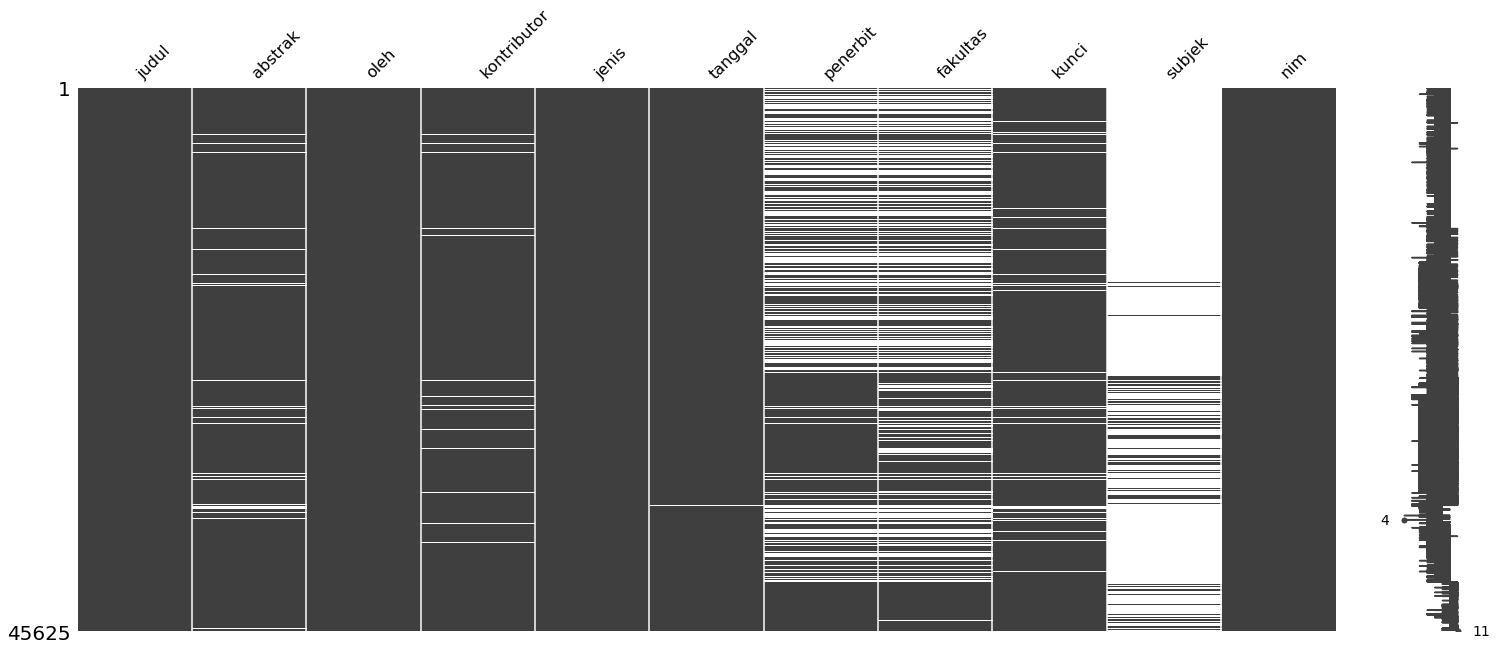

In [19]:
msno.matrix(digi)

## Mencari Data TA Mahasiswa Matematika

Untuk mencari data TA mahasiswa matematika, saya memilih untuk mengambil informasi di kolom `nim` (mahasiswa matematika memiliki NIM dengan awalan '101'). Hal ini jauh lebih baik ketimbang menggunakan informasi di kolom `oleh` (karena ada kemungkinan ada penulis yang memiliki nama yang sama dengan seorang mahasiswa matematika)

In [23]:
data = []
for idx in digi.index:
    if str(digi['nim'][idx])[:3]=='101': data.append(idx)

maths1 = digi.loc[data].fillna('')

In [24]:
maths1

,judul,abstrak,oleh,kontributor,jenis,tanggal,penerbit,fakultas,kunci,subjek,nim
10040,MODEL PENYEBARAN PENYAKIT AFRICAN HORSE SICKNE...,Tugas akhir ini membahas masalah model penyeba...,Asnaini Maulidia,Pembimbing: Dr. Nuning Nuraini,S1-Tugas Akhir,2017-09-27 11:43:07,,,"basic reproduction number, titik kesetimbangan...",,10103037
10048,PEMBUATAN PORTFOLIO OPTIMAL YANG ROBUST DENGAN...,Pembuatan portfolio dalam keuangan dengan meng...,Astrid Ayuningtyas,Pembimbing: Dr. Roberd Saragih dan Dr. Jalina ...,S1-Tugas Akhir,2017-09-27 11:43:06,,,"Mean-Variansi Markowitz, Outlier, Jarak Mahala...",,10104055
10062,PENGGUNAAN SKEMA BAGI RAHASIA UNTUK MELAKUKAN ...,Skema bagi rahasia merupakan salah satu metode...,Ayatullah Arruhul Amin,Pembimbing: Dr. Rinovia M. G. Simanjuntak,S1-Tugas Akhir,2017-09-27 11:43:05,,,"polinom, skema bagi rahasia, field, query",,10103061
10064,EFISIENSI PENDESAKAN MINYAK PADA LOW-TENSION F...,Low-Tension Flood merupakan salah satu metode ...,Ayu Fitra Sari,Pembimbing: Prof.Dr. Edy Soewono dan Prof.Dr.I...,S1-Tugas Akhir,2017-09-27 11:43:06,,,"Low-Tension Flood, Injeksi Surfactant, persama...",,10104077
10065,PELABELAN TOTAL LINGKARAN AJAIB SUPER PADA GRA...,"Pada tugas akhir ini, dibuktikan bahwa suatu g...",Ayuningtyas,Pembimbing: Dr. M. Salman A.N,S1-Tugas Akhir,2017-09-27 11:43:08,,,"pelabelan total ajaib super, Cn - cactus, graf...",,10105066
...,...,...,...,...,...,...,...,...,...,...,...
44844,SIMULASI BERBAGAI KONDISI LALU LINTAS DENGAN C...,Dalam tugas akhir ini permasalahan lalu lintas...,Nopi Mirnawati,"Prof. Dr. Sri Redjeki Pudjaprasetya F., MS;",S1-Tugas Akhir,2019-11-11 09:38:32,FMIPA - Matematika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,"Cell Transmission Model, traffic light",,10111084
45322,"PERBANDINGAN ANALISIS RECENCY, FREQUENCY, MONE...",Mal 23 Paskal merupakan salah satu pusat perbe...,Vivian Chan,"Dr. RR. Kurnia Novita Sari, S.Si.,",S1-Tugas Akhir,2019-12-12 15:34:46,FMIPA - Matematika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,"segmentasi pelanggan, program loyalitas, corne...",,10115063
45417,MODEL PENENTUAN STRATEGI PEMASARAN TERBAIK DI ...,Industri minuman olahan saat ini telah berkemb...,Annisa Deliananda,"Dr. Nuning Nuraini, S.Si., M.Si",S1-Tugas Akhir,2019-12-19 11:00:32,FMIPA - Matematika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,"Industri minuman olahan, pemodelan, optimisasi...",,10115071
45594,MODEL PERTUMBUHAN POPULASI REPUBLIK RAKYAT CIN...,Republik Rakyat Cina (RRC) telah menjadi negar...,Gracia Natania,"Dr. Nuning Nuraini, S.Si., M.Si",S1-Tugas Akhir,2020-01-08 13:29:13,FMIPA - Matematika,Fakultas Matematika dan Ilmu Pengetahuan Alam ...,"penduduk Republik Rakyat Cina, populasi peremp...",,10115021


In [25]:
maths1.to_csv('mathS1.csv', sep='$', index=False)

[Versi Google Sheet](https://docs.google.com/spreadsheets/d/1xsinp7_3WxK3Z08Jlxygv48XV-EF0K6pIZoB6JBSEs8/edit?usp=sharing)